In [ ]:
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
sys.path.append("/content/drive/MyDrive/2023-2024/Thesis/python_files")

from pycocotools.coco import COCO
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import os
import cv2
import PIL
import requests
from PIL import Image, ImageDraw
from tqdm import tqdm
from google.colab import output
import matplotlib.pyplot as plt
import pickle, time, argparse, random
from os import path, makedirs
import torch
import json
from pycocotools.coco import COCO

from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import average_precision_score

coco = COCO('/content/drive/MyDrive/2023-2024/Thesis/annotations/instances_val2014.json')

Mounted at /content/drive
loading annotations into memory...
Done (t=12.26s)
creating index...
index created!


In [ ]:
# create presence absence array for each image's objects (tensor)
# dict where each key is imgpath and value is tensor
# lbls_pkl = pickle.load(open("/content/gender_labels_test.pkl", "rb"))
# print(lbls_pkl)


def id_to_imgpath(id, dir):
    # id is a 12 digit number so pad id with zeros
    zerofilled_id=str(id).zfill(12)

    #/content/drive/MyDrive/2023-2024/Thesis/grayscale_val/COCO_val2014_000000089099.jpg
    return "/content/" + dir + "/COCO_val2014_" + zerofilled_id + ".jpg"
    #return "/content/drive/MyDrive/2023-2024/Thesis/grayscale_" + testorval + "/COCO_" + testorval + "2014_"+zerofilled_id +".jpg"

def create_objects_labels_pickle(filename):
  labels = {} # create dictionary mapping image path to object tensor
  labels_domain = {} # create dictionary mapping image path to object tensor with domain
  skin_labels = {"Light":0,"Dark":1}
  images_2014 = pd.read_csv("/content/drive/MyDrive/2023-2024/Thesis/COCO 2014 Val Demographic Annotations/images_val2014.csv")
  light_objs = []
  dark_objs = []
  light_objs_ids = []
  dark_objs_ids = []


  # grab only the images containing light (1) or dark (0) labels
  for skin_label in list(skin_labels.keys()):
      print('Creating ' + skin_label + ' data...')
      data = images_2014[list(images_2014['bb_skin'] == skin_label)]
      #print(data)


      for count, row in enumerate(range(data.shape[0])):
        if (count % 100 == 0):
          print(count)

        image_id = list(data['id'])[row]

        imgpath = id_to_imgpath(image_id, "standard")
        ann_ids = coco.getAnnIds(image_id, iscrowd=False)
        person_ids = coco.getAnnIds(image_id, catIds=[1], iscrowd=False)
        object_ids = list(set(ann_ids) ^ set(person_ids))
        object_anns = coco.loadAnns(object_ids)
        # print(imgpath)
        object_cat_ids = []

        for object_ann in object_anns:
          object_cat_ids.append(object_ann["category_id"])

        pa_array = [0] * len(coco.getCatIds())

        for index, cat_id in enumerate(coco.getCatIds()):


          if cat_id in object_cat_ids:
            pa_array[index] = 1
          else:
            pa_array[index] = 0


        labels[imgpath] = np.array(pa_array)

        # print(pa_array)
        if skin_label == "Light":
          light_objs.append(labels[imgpath])
          light_objs_ids.append(imgpath)
          labels_domain[imgpath] = np.append(pa_array[1:], 0)
        else:
          dark_objs.append(labels[imgpath])
          dark_objs_ids.append(imgpath)
          labels_domain[imgpath] = np.append(pa_array[1:], 1)









  # with open("/content/drive/MyDrive/2023-2024/Thesis/skin_labels_" + filename + ".pkl", 'wb') as handle:
  #     pickle.dump(labels, handle, protocol=4)

  # with open("/content/drive/MyDrive/2023-2024/Thesis/skin_labels_objects_domain.pkl", 'wb') as handle:
  #     pickle.dump(labels_domain, handle, protocol=4)

  # with open("/content/drive/MyDrive/2023-2024/Thesis/light_skin_objects.pkl", 'wb') as handle:
  #     pickle.dump(light_objs, handle, protocol=4)

  # with open("/content/drive/MyDrive/2023-2024/Thesis/light_skin_objects_ids.pkl", 'wb') as handle:
  #     pickle.dump(light_objs_ids, handle, protocol=4)

  # with open("/content/drive/MyDrive/2023-2024/Thesis/dark_skin_objects.pkl", 'wb') as handle:
  #     pickle.dump(dark_objs, handle, protocol=4)

  # with open("/content/drive/MyDrive/2023-2024/Thesis/dark_skin_objects_ids.pkl", 'wb') as handle:
  #     pickle.dump(dark_objs_ids, handle, protocol=4)

  return labels, light_objs, dark_objs, light_objs_ids, dark_objs_ids


obj_labels, light_objs, dark_objs, light_objs_ids, dark_objs_ids = create_objects_labels_pickle("objects")


Creating Light data...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
Creating Dark data...
0
100
200
300
400
500
600
700
800
900
1000


In [ ]:
wb_anns = pickle.load(open("/content/drive/MyDrive/2023-2024/Thesis/whole_body_annotations.pkl", "rb"))
def id_to_imgpath(id, dir):
    # id is a 12 digit number so pad id with zeros
    zerofilled_id=str(id).zfill(12)

    #/content/drive/MyDrive/2023-2024/Thesis/grayscale_val/COCO_val2014_000000089099.jpg
    return "/content/" + dir + "/COCO_val2014_" + zerofilled_id + ".jpg"
    #return "/content/drive/MyDrive/2023-2024/Thesis/grayscale_" + testorval + "/COCO_" + testorval + "2014_"+zerofilled_id +".jpg"

In [ ]:
test_key_list = pickle.load(open('/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard_test.pkl', 'rb'))
val_key_list = pickle.load(open('/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard_val.pkl', 'rb'))

num_light_face = 0
num_dark_face = 0
num_light_l_hand = 0
num_dark_l_hand = 0
num_light_r_hand = 0
num_dark_r_hand = 0
num_light_foot = 0
num_dark_foot = 0
num_dark_test_foot = 0
num_dark_val_foot = 0
for imgid, anns in wb_anns.items():
  if anns[0]['face_valid']:
    if id_to_imgpath(imgid, "standard") in light_objs_ids:
      num_light_face+=1
    if id_to_imgpath(imgid, "standard") in dark_objs_ids:
      num_dark_face+=1
  if anns[0]['lefthand_valid']:
    if id_to_imgpath(imgid, "standard") in light_objs_ids:
      num_light_l_hand+=1
    if id_to_imgpath(imgid, "standard") in dark_objs_ids:
      num_dark_l_hand+=1
  if anns[0]['righthand_valid']:
    if id_to_imgpath(imgid, "standard") in light_objs_ids:
      num_light_r_hand+=1
    if id_to_imgpath(imgid, "standard") in dark_objs_ids:
      num_dark_r_hand+=1
  if anns[0]['foot_valid']:
    if id_to_imgpath(imgid, "standard") in light_objs_ids:
      num_light_foot+=1
    if id_to_imgpath(imgid, "standard") in dark_objs_ids:
      if id_to_imgpath(imgid, "standard") in test_key_list:
        num_dark_test_foot+=1
      if id_to_imgpath(imgid, "standard") in val_key_list:
        num_dark_val_foot+=1
      num_dark_foot+=1
  if anns[0]['face_valid'] and anns[0]['lefthand_valid'] and anns[0]['righthand_valid'] and anns[0]['foot_valid'] and id_to_imgpath(imgid, "standard") not in test_key_list and id_to_imgpath(imgid, "standard") in dark_objs_ids:
    print(imgid)

light_total = 9873
dark_total = 1096
print("Num light with face", num_light_face, num_light_face / light_total * 100)
print("Num dark with face", num_dark_face, num_dark_face / dark_total * 100)
print("Num light with lhand", num_light_l_hand, num_light_l_hand / light_total * 100)
print("Num dark with lhand", num_dark_l_hand, num_dark_l_hand / dark_total * 100)
print("Num light with rhand", num_light_r_hand, num_light_r_hand / light_total * 100)
print("Num dark with rhand", num_dark_r_hand, num_dark_r_hand / dark_total * 100)
print("Num light with foot", num_light_foot, num_light_foot / light_total * 100)
print("Num dark with foot", num_dark_foot, num_dark_foot / dark_total * 100)
print("Num dark train with foot", num_dark_foot - num_dark_test_foot - num_dark_val_foot)
print("Num dark test with foot", num_dark_test_foot)
print("Num dark val with foot", num_dark_val_foot)

327601
382111
31093
69356
272566
214539
19432
431693
79031
187734
522889
321476
240340
86800
281111
462345
120099
258078
435136
473839
248224
37875
367953
97748
223198
392506
571029
302767
558457
161586
423668
419444
288174
356421
509227
542755
398423
54796
557107
331367
355660
112394
533962
341678
205636
190081
515219
461945
467752
528091
Num light with face 5755 58.290286640332226
Num dark with face 673 61.40510948905109
Num light with lhand 5111 51.76744657145751
Num dark with lhand 557 50.82116788321168
Num light with rhand 5490 55.606198723792154
Num dark with rhand 582 53.102189781021906
Num light with foot 2192 22.20196495492758
Num dark with foot 220 20.072992700729927
Num dark train with foot 149
Num dark test with foot 32
Num dark val with foot 39


In [ ]:
# dict where key is index and val is human cat name
onehot_to_human_labels = {}
cat_list = coco.getCatIds()
for index, cat_id in enumerate(cat_list):
  if cat_id == 51:
    print(index)
  cat = coco.loadCats(cat_id)[0]["name"]
  onehot_to_human_labels[index] = cat


#[51, 51, 55, 55, 51, 51, 51, 51, 51, 53, 53, 55, 55, 51, 55, 51, 51, 53, 51, 55, 55, 51, 55, 55, 55, 51, 55, 55, 55, 55]
print(onehot_to_human_labels)
print()

45
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'mic

In [ ]:
img_labels = pickle.load(open("/content/drive/MyDrive/2023-2024/Thesis/skin_labels.pkl", "rb"))
print(len(img_labels.keys()))

10969


Identify Image IDs of F/M containing the top 10 objects identified by logistic regression classifier.

Object Occurence Analysis

In [ ]:
# F_objects = pickle.load(open('F_objects.pkl', 'rb')) # list of F (darker skinned) image's one hot encoding of objects
# M_objects = pickle.load(open('M_objects.pkl', 'rb')) # list of M (lighter skinned) image's one hot encoding of objects
F_objects = dark_objs
M_objects = light_objs
# humanlabels_to_onehot = pickle.load(open('humanlabels_to_onehot.pkl', 'rb'))

# onehot_to_humanlabels = dict((y,x) for x,y in humanlabels_to_onehot.items())
onehot_to_humanlabels = onehot_to_human_labels

In [ ]:
# replace M/F_objects with a list of indices where each one hot encoding is converted into indices where it equals one
F_obj_idx, M_obj_idx = [], []
for one_hot_enc in F_objects:
  F_obj_idx.append(np.where(one_hot_enc>0)[0])

for one_hot_enc in M_objects:
  M_obj_idx.append(np.where(one_hot_enc>0)[0])


In [ ]:
F_IMGS = len(F_obj_idx)
M_IMGS = len(M_obj_idx)
print("F_IMGS: ", F_IMGS)
print("M_IMGS: ", M_IMGS)

F_IMGS:  1096
M_IMGS:  9873


In [ ]:
# create a F/M dictionary mapping object idx to object count
F_obj_count, M_obj_count = F_obj_count, M_obj_count = dict.fromkeys(onehot_to_human_labels.keys(), 0), dict.fromkeys(onehot_to_human_labels.keys(), 0)
for obj_idx in F_obj_idx:
  for obj in obj_idx:
    F_obj_count[obj]+=1

for obj_idx in M_obj_idx:
  for obj in obj_idx:
    M_obj_count[obj]+=1

for obj_idx in list(F_obj_count.keys()):
  F_obj_count[obj_idx] = F_obj_count[obj_idx]/F_IMGS

for obj_idx in list(M_obj_count.keys()):
  M_obj_count[obj_idx] = M_obj_count[obj_idx]/M_IMGS

In [ ]:
F_obj_count_full = F_obj_count
M_obj_count_full = M_obj_count

In [ ]:
# create dict for all objects
def load_pkl(load_path):
    with open(load_path, 'rb') as f:
        pkl_data = pickle.load(f)
    return pkl_data

total_obj_count = {}

for obj_idx in M_obj_count_full:
  total_obj_count[obj_idx] = M_obj_count_full[obj_idx] + F_obj_count_full[obj_idx]
print(total_obj_count)

test_obj_count = {}

test_key_list = list(load_pkl('/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard_test.pkl'))
light_objs_ids = load_pkl('/content/drive/MyDrive/2023-2024/Thesis/light_skin_objects_ids.pkl')
dark_objs_ids = load_pkl('/content/drive/MyDrive/2023-2024/Thesis/dark_skin_objects_ids.pkl')


F_objects_t = []
M_objects_t = []
for key, value in obj_labels.items():
  if key in test_key_list and key in light_objs_ids:
    M_objects_t.append(value)
  elif key in test_key_list and key in dark_objs_ids:
    F_objects_t.append(value)


# replace M/F_objects with a list of indices where each one hot encoding is converted into indices where it equals one
F_obj_idx_t, M_obj_idx_t = [], []
for one_hot_enc in F_objects_t:
  F_obj_idx_t.append(np.where(one_hot_enc>0)[0])

for one_hot_enc in M_objects_t:
  M_obj_idx_t.append(np.where(one_hot_enc>0)[0])
  # if not np.where(one_hot_enc>0)[0]:
  #   F_obj_idx.append(np.empty())


F_obj_count_t, M_obj_count_t = dict.fromkeys(onehot_to_human_labels.keys(), 0), dict.fromkeys(onehot_to_human_labels.keys(), 0)
for obj_idx in F_obj_idx_t:
  for obj in obj_idx:
    F_obj_count_t[obj]+=1

for obj_idx in M_obj_idx_t:
  for obj in obj_idx:
    M_obj_count_t[obj]+=1

for obj_idx in M_obj_count_t:
  test_obj_count[obj_idx] = M_obj_count_t[obj_idx] + F_obj_count_t[obj_idx]

print(test_obj_count)

val_obj_count = {}

val_key_list = list(load_pkl('/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard_val.pkl'))
light_objs_ids = load_pkl('/content/drive/MyDrive/2023-2024/Thesis/light_skin_objects_ids.pkl')
dark_objs_ids = load_pkl('/content/drive/MyDrive/2023-2024/Thesis/dark_skin_objects_ids.pkl')


F_objects_v = []
M_objects_v = []
for key, value in obj_labels.items():
  if key in val_key_list and key in light_objs_ids:
    M_objects_v.append(value)
  elif key in val_key_list and key in dark_objs_ids:
    F_objects_v.append(value)


# replace M/F_objects with a list of indices where each one hot encoding is converted into indices where it equals one
F_obj_idx_v, M_obj_idx_v = [], []
for one_hot_enc in F_objects_v:
  F_obj_idx_v.append(np.where(one_hot_enc>0)[0])

for one_hot_enc in M_objects_v:
  M_obj_idx_v.append(np.where(one_hot_enc>0)[0])
  # if not np.where(one_hot_enc>0)[0]:
  #   F_obj_idx.append(np.empty())


F_obj_count_v, M_obj_count_v = dict.fromkeys(onehot_to_human_labels.keys(), 0), dict.fromkeys(onehot_to_human_labels.keys(), 0)
for obj_idx in F_obj_idx_v:
  for obj in obj_idx:
    F_obj_count_v[obj]+=1

for obj_idx in M_obj_idx_v:
  for obj in obj_idx:
    M_obj_count_v[obj]+=1

for obj_idx in M_obj_count_v:
  val_obj_count[obj_idx] = M_obj_count_v[obj_idx] + F_obj_count_v[obj_idx]


print(val_obj_count)


{0: 0, 1: 305, 2: 869, 3: 330, 4: 29, 5: 154, 6: 80, 7: 357, 8: 146, 9: 143, 10: 72, 11: 54, 12: 25, 13: 678, 14: 83, 15: 113, 16: 307, 17: 255, 18: 49, 19: 70, 20: 121, 21: 9, 22: 5, 23: 56, 24: 736, 25: 491, 26: 974, 27: 872, 28: 252, 29: 440, 30: 377, 31: 165, 32: 947, 33: 193, 34: 446, 35: 467, 36: 637, 37: 471, 38: 877, 39: 1070, 40: 396, 41: 1096, 42: 378, 43: 512, 44: 398, 45: 652, 46: 179, 47: 80, 48: 233, 49: 76, 50: 49, 51: 81, 52: 190, 53: 395, 54: 207, 55: 379, 56: 1739, 57: 511, 58: 370, 59: 297, 60: 1297, 61: 80, 62: 385, 63: 427, 64: 113, 65: 514, 66: 120, 67: 936, 68: 100, 69: 244, 70: 8, 71: 221, 72: 197, 73: 515, 74: 274, 75: 160, 76: 100, 77: 184, 78: 32, 79: 156}
{0: 0, 1: 59, 2: 172, 3: 71, 4: 2, 5: 29, 6: 15, 7: 76, 8: 24, 9: 24, 10: 13, 11: 10, 12: 2, 13: 145, 14: 14, 15: 25, 16: 61, 17: 45, 18: 5, 19: 17, 20: 21, 21: 1, 22: 1, 23: 10, 24: 150, 25: 106, 26: 203, 27: 165, 28: 43, 29: 97, 30: 84, 31: 34, 32: 186, 33: 40, 34: 94, 35: 92, 36: 127, 37: 82, 38: 172, 39

In [ ]:
label_obj_count = {}
label_obj_count_test = {}
label_obj_count_val = {}
for obj_idx, count in total_obj_count.items():
  label_obj_count[onehot_to_humanlabels[obj_idx]] = count
for obj_idx, count in test_obj_count.items():
  label_obj_count_test[onehot_to_humanlabels[obj_idx]] = count
for obj_idx, count in val_obj_count.items():
  label_obj_count_val[onehot_to_humanlabels[obj_idx]] = count

# label_obj_count = {label: count for label, count in sorted(label_obj_count.items(), key=lambda x: x[1])}
# label_obj_count_test = {label: count for label, count in sorted(label_obj_count_test.items(), key=lambda x: x[1])}
print({label: count for label, count in sorted(label_obj_count.items(), key=lambda x: x[1])})
# label_obj_count_test = {label: count for label, count in sorted(label_obj_count_test.items(), key=lambda x: x[1])}
print({label: count for label, count in sorted(label_obj_count_test.items(), key=lambda x: x[1])})
print({label: count for label, count in sorted(label_obj_count_val.items(), key=lambda x: x[1])})

{'person': 0, 'zebra': 5, 'toaster': 8, 'bear': 9, 'parking meter': 25, 'airplane': 29, 'hair drier': 32, 'sheep': 49, 'broccoli': 49, 'stop sign': 54, 'giraffe': 56, 'cow': 70, 'fire hydrant': 72, 'orange': 76, 'train': 80, 'apple': 80, 'toilet': 80, 'carrot': 81, 'bird': 83, 'microwave': 100, 'scissors': 100, 'cat': 113, 'mouse': 113, 'keyboard': 120, 'elephant': 121, 'traffic light': 143, 'boat': 146, 'bus': 154, 'toothbrush': 156, 'vase': 160, 'snowboard': 165, 'banana': 179, 'teddy bear': 184, 'hot dog': 190, 'kite': 193, 'refrigerator': 197, 'donut': 207, 'sink': 221, 'sandwich': 233, 'oven': 244, 'suitcase': 252, 'horse': 255, 'clock': 274, 'bed': 297, 'bicycle': 305, 'dog': 307, 'motorcycle': 330, 'truck': 357, 'potted plant': 370, 'skis': 377, 'fork': 378, 'cake': 379, 'tv': 385, 'pizza': 395, 'wine glass': 396, 'spoon': 398, 'laptop': 427, 'frisbee': 440, 'baseball bat': 446, 'baseball glove': 467, 'surfboard': 471, 'umbrella': 491, 'couch': 511, 'knife': 512, 'remote': 514, 

In [ ]:
M_obj_count_full = {label: count for label, count in sorted(M_obj_count_full.items())}
F_obj_count_full = {label: count for label, count in sorted(F_obj_count_full.items())}
M_obj_count_t = {label: count for label, count in sorted(M_obj_count_t.items())}
F_obj_count_t = {label: count for label, count in sorted(F_obj_count_t.items())}
M_obj_count_v = {label: count for label, count in sorted(M_obj_count_v.items())}
F_obj_count_v = {label: count for label, count in sorted(F_obj_count_v.items())}
print(M_obj_count_t)
print(F_obj_count_t)
print(test_obj_count)
print(M_obj_count_v)
print(F_obj_count_v)
print(val_obj_count)

{0: 0, 1: 49, 2: 148, 3: 53, 4: 2, 5: 22, 6: 12, 7: 55, 8: 22, 9: 16, 10: 13, 11: 9, 12: 2, 13: 134, 14: 11, 15: 24, 16: 60, 17: 44, 18: 4, 19: 13, 20: 12, 21: 0, 22: 1, 23: 10, 24: 135, 25: 88, 26: 180, 27: 153, 28: 35, 29: 90, 30: 84, 31: 34, 32: 167, 33: 36, 34: 82, 35: 79, 36: 111, 37: 72, 38: 154, 39: 200, 40: 76, 41: 192, 42: 63, 43: 103, 44: 78, 45: 119, 46: 22, 47: 18, 48: 53, 49: 15, 50: 8, 51: 12, 52: 34, 53: 61, 54: 40, 55: 84, 56: 327, 57: 87, 58: 74, 59: 57, 60: 237, 61: 16, 62: 76, 63: 74, 64: 22, 65: 85, 66: 20, 67: 169, 68: 17, 69: 50, 70: 3, 71: 40, 72: 30, 73: 96, 74: 61, 75: 40, 76: 27, 77: 53, 78: 7, 79: 30}
{0: 0, 1: 10, 2: 24, 3: 18, 4: 0, 5: 7, 6: 3, 7: 21, 8: 2, 9: 8, 10: 0, 11: 1, 12: 0, 13: 11, 14: 3, 15: 1, 16: 1, 17: 1, 18: 1, 19: 4, 20: 9, 21: 1, 22: 0, 23: 0, 24: 15, 25: 18, 26: 23, 27: 12, 28: 8, 29: 7, 30: 0, 31: 0, 32: 19, 33: 4, 34: 12, 35: 13, 36: 16, 37: 10, 38: 18, 39: 17, 40: 7, 41: 18, 42: 7, 43: 13, 44: 7, 45: 14, 46: 10, 47: 2, 48: 4, 49: 1, 50:

In [ ]:
df_dict = {}
df_dict["object"] = list(onehot_to_humanlabels.values())
df_dict["full count"] = list(total_obj_count.values())
df_dict["test count"] = list(test_obj_count.values())
df_dict["full count l"] = list(M_obj_count_full.values())
df_dict["full count d"] = list(F_obj_count_full.values())
df_dict["test count d"] = list(F_obj_count_t.values())
df_dict["test count l"] = list(M_obj_count_t.values())
df_dict["val count d"] = list(F_obj_count_v.values())
df_dict["val count l"] = list(M_obj_count_v.values())


In [ ]:
df = pd.DataFrame(df_dict)
print(len(F_objects_v) + len(M_objects_v))
print(len(F_objects_v), len(M_objects_v))
df.drop(index = 0, inplace = True)
print(df)
with open("/content/drive/MyDrive/2023-2024/Thesis/objects_df.pkl", 'wb') as handle:
  pickle.dump(df, handle, protocol=4)

2194
213 1981
        object  full count  test count  full count l  full count d  \
1      bicycle         305          59           255            50   
2          car         869         172           763           106   
3   motorcycle         330          71           266            64   
4     airplane          29           2            26             3   
5          bus         154          29           117            37   
..         ...         ...         ...           ...           ...   
75        vase         160          44           152             8   
76    scissors         100          28            93             7   
77  teddy bear         184          55           178             6   
78  hair drier          32           7            31             1   
79  toothbrush         156          33           147             9   

    test count d  test count l  val count d  val count l  
1             10            49            7           38  
2             24           

In [ ]:
df = load_pkl('/content/drive/MyDrive/2023-2024/Thesis/objects_df.pkl')
df.drop(index = 0, inplace = True)
print(df)
with open("/content/drive/MyDrive/2023-2024/Thesis/objects_df.pkl", 'wb') as handle:
  pickle.dump(df, handle, protocol=4)

        object  full count  test count  full count l  full count d  \
1      bicycle         305          59           255            50   
2          car         869         172           763           106   
3   motorcycle         330          71           266            64   
4     airplane          29           2            26             3   
5          bus         154          29           117            37   
..         ...         ...         ...           ...           ...   
75        vase         160          44           152             8   
76    scissors         100          28            93             7   
77  teddy bear         184          55           178             6   
78  hair drier          32           7            31             1   
79  toothbrush         156          33           147             9   

    test count d  test count l  val count d  val count l  
1             10            49           10           49  
2             24           148           

In [ ]:
per_class_ap = [-0.0, 0.8146324020191253, 0.7954170137357244, 0.9446711796514037, 0.3970774301021427, 0.8797837297049631, 0.8761424291569077, 0.7916529537019323, 0.8283621295521498, 0.859153073146195, 0.8447338749951987, 0.9271895700958628, 0.7777879668977857, 0.7826931271465782, 0.7784842301387302, 0.7984132605806026, 0.8807437714794966, 0.9614276538552432, 0.950622439191397, 0.9617969771317361, 0.9961994265516168, 0.9149291075896581, 0.9990892531876139, 0.99911097179985, 0.6469800105295536, 0.8642066368346277, 0.6698056570375885, 0.8976311416386538, 0.846214084296455, 0.9377874588405445, 0.9814461088856425, 0.9496818462306406, 0.9038280847063632, 0.9167004534044737, 0.956874837451819, 0.983391744507327, 0.957851639403963, 0.9615666318033849, 0.9860968073097421, 0.7180074308385154, 0.8489110966296979, 0.7972189093980547, 0.9139341944536757, 0.8813488719865649, 0.8786848373464786, 0.8782198845251356, 0.8880111260540746, 0.8532847211789478, 0.8521708593706687, 0.9455483435233236, 0.9211424060491004, 0.7611615593141919, 0.8807049998801572, 0.9583351223445964, 0.8793342152184476, 0.921495581746131, 0.7644106762943844, 0.8752567910423565, 0.8003473895053785, 0.8873376992168566, 0.8621338313810214, 0.8981893909905088, 0.8907925703473628, 0.8977813598102268, 0.932254141923597, 0.9134482550525428, 0.9364047964530324, 0.7354067363285112, 0.8822575130266315, 0.9175455502568333, 0.9465411648254922, 0.904973367227997, 0.842825228666555, 0.7821779214513346, 0.6885867377807383, 0.8153394469874949, 0.7211191136275509, 0.9120726411841291, 0.7810542136382334, 0.9390077990560708]
per_class_ap_diff = [0.0, -0.04678477331542252, 0.012164312564408308, -0.018635225737187233, 0.4279864048738232, -0.044748767838975856, -0.10323399913585518, -0.16269391794716648, -0.1855587409498456, -0.08790192755725201, 0.8599721755022501, 0.03439776183479859, 0.8040356685268191, 0.021702726521704907, -0.09008388828575475, -0.20518141575989124, -0.11482146459543019, -0.03531234860346888, 0.1293790141790656, -0.007209828610802549, 0.00013407038654900116, -0.99096657633243, 0.9990892531876139, 0.9991109717998501, 0.0763171244786478, -0.030330087954006046, 0.09028040911532875, 0.03681711238239438, -0.08933622791764828, -0.05416064505122242, 0.9826960958287954, 0.9530013850334835, -0.02268612140428994, 0.04680454661691025, -0.020118052400524666, -0.0018742372901084936, -0.008002867351238785, 0.025306552070907706, 0.025200875723789817, 0.03282719398827194, 0.04572029359964258, 0.04358173309400393, -0.03463888879640087, -0.07096087582111565, 0.05364854616009018, 0.025162238684078964, -0.18519081628194523, -0.14047381279562332, 0.10016784854901661, 0.14335247177017818, -0.0758393084199569, 0.7771181024204075, -0.03561138364570382, -0.0017814510148339568, -0.025590155628459454, 0.05429394112840347, 0.008699285988529648, 0.12624053220445064, -0.11765709370697175, -0.0722055695774283, -0.027404411643098592, 0.024792232842664297, -0.0572805505067866, -0.06816686714154918, -0.07622525715923578, -0.06581716563020568, -0.06112682744491893, 0.044050695152403896, -0.012770811948658256, 0.08440380730706609, 0.9485028569832814, 0.0003174247844667244, -0.1418628528937952, 0.05906870863283753, 0.08492764945737774, -0.1681933443801289, -0.086073045836496, 0.3363178173523992, 0.7931783784214972, -0.06425398659239645]
per_class_ap_grayscale = [-0.0, 0.8042323521422245, 0.7821778838265279, 0.9259231915167111, 0.5331868332239771, 0.8956698888620146, 0.9078559406189913, 0.7946621657184746, 0.8015131371099399, 0.8716143592428369, 0.8081196133827405, 0.9022833391769092, 0.8012490026874948, 0.7408011139857659, 0.700419520775782, 0.767868591900914, 0.8433765040388832, 0.952812842560413, 0.9860727601550436, 0.8887987218417882, 0.9977204322017066, 0.9597550306211724, 0.6925505050505051, 0.9937436774019573, 0.6779204395477892, 0.8437007750418724, 0.6855493904383402, 0.8621285602826608, 0.8450322947089611, 0.8992749267148694, 0.9780125980360334, 0.9684720547147903, 0.8885019311664989, 0.8804089317232209, 0.9566824830829324, 0.9639765887259452, 0.9496966037605777, 0.9418919080393421, 0.9761324312059239, 0.7226878793246023, 0.7945438949622218, 0.7653435510191336, 0.8770501409492636, 0.8426883977512803, 0.8722484662432997, 0.8639354637243906, 0.9151684152046629, 0.8357748270152414, 0.7785925309650866, 0.92693044636577, 0.8623020757236862, 0.737330833843189, 0.8014112072539725, 0.927904472313115, 0.8184038077083494, 0.8518258330178827, 0.717405328363733, 0.8713511101529285, 0.8027150110407688, 0.8813370180476018, 0.8288673066300124, 0.8422424656940132, 0.8899060262777919, 0.876676046002104, 0.9166324522472039, 0.9066834646826376, 0.9132865354521196, 0.6837869753766752, 0.8196676146336548, 0.8970607732270335, 0.8695988676925982, 0.8857932918046487, 0.8630311042892406, 0.7816593466741404, 0.6764998041108492, 0.8158108825119764, 0.6674136132411611, 0.8766351027707453, 0.8297054590133569, 0.9313286280646165]
per_class_ap_grayscale_diff = [0.0, -0.12636547445470026, -0.020902315223387924, -0.011466176033256392, 0.5679748758213521, 0.004581370698549581, -0.1016511502063685, -0.15208033359250517, -0.21444551922303112, -0.07169734304810538, 0.829215715776082, 0.09161568638432382, 0.8210973290630821, 0.1759395937992172, -0.17163746559174275, -0.23606125356273577, -0.14918384134835483, -0.04269232726852712, -0.009453693752274006, 0.04134766756638264, -0.001295171010857743, -0.9981801637852593, 0.719344262295082, 0.9945055299871306, 0.14286267866654667, -0.09178396570623948, 0.02289560290259307, -0.06674980431350719, -0.05142377617774663, 0.05742755656110787, 0.9792411331250499, 0.9693399249582458, -0.050143290833999155, 0.22203163268193538, -0.017069020736942386, 0.02665641514337369, -0.035463839037288336, -0.045190345164873524, 0.007550383921721249, 0.04140789161439662, 0.0923281667798328, 0.04210928073044906, 0.011143342327384453, -0.09581143760228283, 0.01670758725021304, 0.05467509134219184, -0.1353479240718659, -0.10386587477078635, 0.08242022102754154, -0.05832721649188999, -0.1363778262352947, 0.7562532067120208, 0.03382861385928404, 0.12395344658618224, -0.11183765336014695, -0.026449978624826453, -0.04882220909380819, 0.11653573199053802, -0.025572085636563324, -0.12857075492181957, -0.004912219055431932, 0.1496456855224796, -0.032974563830527215, 0.002091085724125308, -0.041154591131574936, -0.031216206353261167, -0.05083767521291849, 0.11260853399850579, 0.2667076709324123, 0.05728465833968577, 0.8776867898056249, -0.025890748688413567, 0.04497479732398724, 0.10328789768025337, 0.16176724910223006, -0.04561815956899917, 0.21615644999818467, 0.28352845441722063, 0.8389713748655097, 0.019268746024784678]
per_class_ap_segmask = [-0.0, 0.8042323521422245, 0.7821778838265279, 0.9259231915167111, 0.5331868332239771, 0.8956698888620146, 0.9078559406189913, 0.7946621657184746, 0.8015131371099399, 0.8716143592428369, 0.8081196133827405, 0.9022833391769092, 0.8012490026874948, 0.7408011139857659, 0.700419520775782, 0.767868591900914, 0.8433765040388832, 0.952812842560413, 0.9860727601550436, 0.8887987218417882, 0.9977204322017066, 0.9597550306211724, 0.6925505050505051, 0.9937436774019573, 0.6779204395477892, 0.8437007750418724, 0.6855493904383402, 0.8621285602826608, 0.8450322947089611, 0.8992749267148694, 0.9780125980360334, 0.9684720547147903, 0.8885019311664989, 0.8804089317232209, 0.9566824830829324, 0.9639765887259452, 0.9496966037605777, 0.9418919080393421, 0.9761324312059239, 0.7226878793246023, 0.7945438949622218, 0.7653435510191336, 0.8770501409492636, 0.8426883977512803, 0.8722484662432997, 0.8639354637243906, 0.9151684152046629, 0.8357748270152414, 0.7785925309650866, 0.92693044636577, 0.8623020757236862, 0.737330833843189, 0.8014112072539725, 0.927904472313115, 0.8184038077083494, 0.8518258330178827, 0.717405328363733, 0.8713511101529285, 0.8027150110407688, 0.8813370180476018, 0.8288673066300124, 0.8422424656940132, 0.8899060262777919, 0.876676046002104, 0.9166324522472039, 0.9066834646826376, 0.9132865354521196, 0.6837869753766752, 0.8196676146336548, 0.8970607732270335, 0.8695988676925982, 0.8857932918046487, 0.8630311042892406, 0.7816593466741404, 0.6764998041108492, 0.8158108825119764, 0.6674136132411611, 0.8766351027707453, 0.8297054590133569, 0.9313286280646165]
per_class_ap_segmask_diff = [0.0, -0.12636547445470026, -0.020902315223387924, -0.011466176033256392, 0.5679748758213521, 0.004581370698549581, -0.1016511502063685, -0.15208033359250517, -0.21444551922303112, -0.07169734304810538, 0.829215715776082, 0.09161568638432382, 0.8210973290630821, 0.1759395937992172, -0.17163746559174275, -0.23606125356273577, -0.14918384134835483, -0.04269232726852712, -0.009453693752274006, 0.04134766756638264, -0.001295171010857743, -0.9981801637852593, 0.719344262295082, 0.9945055299871306, 0.14286267866654667, -0.09178396570623948, 0.02289560290259307, -0.06674980431350719, -0.05142377617774663, 0.05742755656110787, 0.9792411331250499, 0.9693399249582458, -0.050143290833999155, 0.22203163268193538, -0.017069020736942386, 0.02665641514337369, -0.035463839037288336, -0.045190345164873524, 0.007550383921721249, 0.04140789161439662, 0.0923281667798328, 0.04210928073044906, 0.011143342327384453, -0.09581143760228283, 0.01670758725021304, 0.05467509134219184, -0.1353479240718659, -0.10386587477078635, 0.08242022102754154, -0.05832721649188999, -0.1363778262352947, 0.7562532067120208, 0.03382861385928404, 0.12395344658618224, -0.11183765336014695, -0.026449978624826453, -0.04882220909380819, 0.11653573199053802, -0.025572085636563324, -0.12857075492181957, -0.004912219055431932, 0.1496456855224796, -0.032974563830527215, 0.002091085724125308, -0.041154591131574936, -0.031216206353261167, -0.05083767521291849, 0.11260853399850579, 0.2667076709324123, 0.05728465833968577, 0.8776867898056249, -0.025890748688413567, 0.04497479732398724, 0.10328789768025337, 0.16176724910223006, -0.04561815956899917, 0.21615644999818467, 0.28352845441722063, 0.8389713748655097, 0.019268746024784678]

per_class_ap_light = [-0.0, 0.8073453766593437, 0.7976541326752956, 0.9414818009348519, 0.4279864048738232, 0.8714839657358174, 0.8520409285147631, 0.7440040304731451, 0.8144412590501544, 0.838489045465751, 0.8599721755022501, 0.9357946394025882, 0.8040356685268191, 0.7880627532938805, 0.7690508525384991, 0.7948185842401088, 0.8851785354045698, 0.9646876513965311, 0.9850732419481765, 0.9622727470392035, 0.9973183716341439, -0.0, 0.9990892531876139, 0.9991109717998501, 0.6580973391153943, 0.856675887938638, 0.6837939719612162, 0.9005179017677418, 0.826909321240031, 0.9346723202688303, 0.9826960958287954, 0.9530013850334835, 0.9022568837611862, 0.9198944669206361, 0.9553284254780448, 0.983603425663372, 0.9567044356154852, 0.9647515546103489, 0.9888167166856441, 0.7216404523677754, 0.8530416639946194, 0.8006344328172116, 0.9114091208545656, 0.8728429988053512, 0.8823089550146206, 0.8823253927226694, 0.806681142435196, 0.8372639640324409, 0.8579237442561095, 0.9541433069512573, 0.916023259391978, 0.7771181024204075, 0.8813574918809032, 0.9580797231429945, 0.8783668828439251, 0.9270547769062876, 0.7652837436668637, 0.8863211738359249, 0.790414728378314, 0.8828420904190885, 0.8597690440174955, 0.9023922328426643, 0.883997347868658, 0.893597984867281, 0.9237747428407642, 0.9080618787381468, 0.9285698078623388, 0.7412280280922218, 0.8842038405452093, 0.9286952779186978, 0.9485028569832814, 0.908255327946164, 0.8371764484162485, 0.7880471527508043, 0.6968370607926121, 0.7918270751830003, 0.7271219133925626, 0.9254034109856621, 0.7931783784214972, 0.9324367474629585]
per_class_ap_dark = [-0.0, 0.8541301499747662, 0.7854898201108873, 0.9601170266720391, -0.0, 0.9162327335747933, 0.9552749276506183, 0.9066979484203116, 1.0, 0.926390973023003, -0.0, 0.9013968775677896, -0.0, 0.7663600267721756, 0.8591347408242539, 1.0, 1.0, 1.0, 0.8556942277691109, 0.9694825756500061, 0.9971843012475949, 0.99096657633243, -0.0, -0.0, 0.5817802146367465, 0.8870059758926441, 0.5935135628458874, 0.8637007893853474, 0.9162455491576793, 0.9888329653200527, -0.0, -0.0, 0.9249430051654761, 0.8730899203037259, 0.9754464778785694, 0.9854776629534805, 0.964707302966724, 0.9394450025394412, 0.9636158409618543, 0.6888132583795035, 0.8073213703949769, 0.7570526997232077, 0.9460480096509665, 0.9438038746264669, 0.8286604088545304, 0.8571631540385904, 0.9918719587171412, 0.9777377768280642, 0.7577558957070929, 0.8107908351810791, 0.9918625678119349, -0.0, 0.916968875526607, 0.9598611741578285, 0.9039570384723845, 0.8727608357778841, 0.756584457678334, 0.7600806416314743, 0.9080718220852857, 0.9550476599965168, 0.8871734556605941, 0.8776, 0.9412778983754446, 0.9617648520088302, 1.0, 0.9738790443683525, 0.9896966353072577, 0.6971773329398179, 0.8969746524938675, 0.8442914706116317, -0.0, 0.9079379031616973, 0.9790393013100437, 0.7289784441179668, 0.6119094113352344, 0.9600204195631292, 0.8131949592290586, 0.589085593633263, -0.0, 0.9966907340553549]
per_class_ap_light_segmask = [-0.0, 0.78070805844109, 0.7797702552850061, 0.9265735325492305, 0.5679748758213521, 0.903504900434872, 0.8827763159468015, 0.756098667277955, 0.7855544807769689, 0.8549982575788222, 0.829215715776082, 0.9182924007776924, 0.8210973290630821, 0.7581715424671431, 0.6703631209151573, 0.7639387464372642, 0.8508161586516452, 0.9573076727314729, 0.9860091011660563, 0.9075746223377638, 0.9979007235826911, -0.0, 0.719344262295082, 0.9945055299871306, 0.6962365289448019, 0.8257297915460375, 0.6903452768396996, 0.859407648637915, 0.8321444818325481, 0.9045680949164551, 0.9792411331250499, 0.9693399249582458, 0.8848464048769938, 0.8985588267464466, 0.9542754126902637, 0.9676515892773916, 0.9452276906329213, 0.9361922302526781, 0.9768403081083011, 0.7266250365022424, 0.8015958056758861, 0.7696054116401975, 0.8768442690937247, 0.8291688557686674, 0.873621433132033, 0.8692233715943931, 0.8596304267689188, 0.8290465167051411, 0.7848338672535029, 0.9272972219627371, 0.8474786760068578, 0.7562532067120208, 0.802721523639251, 0.9387502120024027, 0.8125833952982481, 0.8507541148639328, 0.7144728473014805, 0.881414866472576, 0.8017490549585854, 0.8714292450781804, 0.8278351761729849, 0.8546585389929167, 0.8853231754802127, 0.8785929394161717, 0.914031542721269, 0.9047765793386737, 0.9091514224986201, 0.6966446501660106, 0.8365778008025422, 0.9071202551584198, 0.8776867898056249, 0.8859305919336267, 0.8684165931333686, 0.7890528186532401, 0.6881928873977998, 0.8139033070758671, 0.6871740541201254, 0.8902508982347126, 0.8389713748655097, 0.9317263381727492]
per_class_ap_dark_segmask = [-0.0, 0.9070735328957903, 0.800672570508394, 0.9380397085824869, -0.0, 0.8989235297363224, 0.98442746615317, 0.9081790008704602, 1.0, 0.9266956006269276, -0.0, 0.8266767143933685, -0.0, 0.5822319486679259, 0.8420005865069, 1.0, 1.0, 1.0, 0.9954627949183303, 0.8662269547713811, 0.9991958945935489, 0.9981801637852593, -0.0, -0.0, 0.5533738502782553, 0.917513757252277, 0.6674496739371065, 0.9261574529514222, 0.8835682580102947, 0.8471405383553472, -0.0, -0.0, 0.934989695710993, 0.6765271940645112, 0.9713444334272061, 0.9409951741340179, 0.9806915296702097, 0.9813825754175516, 0.9692899241865799, 0.6852171448878458, 0.7092676388960533, 0.7274961309097484, 0.8657009267663403, 0.9249802933709502, 0.85691384588182, 0.8145482802522013, 0.9949783508407847, 0.9329123914759274, 0.7024136462259614, 0.9856244384546271, 0.9838565022421525, -0.0, 0.7688929097799669, 0.8147967654162205, 0.924421048658395, 0.8772040934887593, 0.7632950563952887, 0.764879134482038, 0.8273211405951487, 1.0, 0.8327473952284168, 0.7050128534704371, 0.9182977393107399, 0.8765018536920464, 0.9551861338528439, 0.9359927856919349, 0.9599890977115386, 0.5840361161675048, 0.5698701298701299, 0.849835596818734, -0.0, 0.9118213406220402, 0.8234417958093814, 0.6857649209729867, 0.5264256382955698, 0.8595214666448663, 0.47101760412194077, 0.606722443817492, -0.0, 0.9124575921479645]
per_class_ap_light_grayscale = [-0.0, 0.7873799456614867, 0.7409976588831709, 0.9416843972756843, 0.6659572243136738, 0.8520575857752105, 0.8042060636195887, 0.6709044240544606, 0.7795384961591549, 0.796756705930273, 0.8267159085412588, 0.9213806846919008, 0.8515223095387627, 0.7857902023121885, 0.7308652982281786, 0.7286611789096715, 0.8617362718972374, 0.9517803290353475, 0.9026038345023972, 0.9561305836529238, 0.9971745193013356, -0.0, 0.9963669391462306, 0.9958957989323801, 0.667965012326474, 0.8675930086338715, 0.6661828981986394, 0.9044751123461265, 0.8297175096482287, 0.9111607386514372, 0.989692732992711, 0.9631334977686176, 0.8943619902470357, 0.9207125356490394, 0.9408968157140708, 0.9793722231374823, 0.9502916180554493, 0.9591979817497102, 0.9781068072321849, 0.7580165354393589, 0.8177094547688055, 0.7883003765216997, 0.8977391768325514, 0.8689234044500812, 0.8660108888018901, 0.8608913259586891, 0.7849349701387901, 0.7642157811325908, 0.821699202848871, 0.8762196848440758, 0.8840727654645322, 0.7939651647352073, 0.814607548145253, 0.9309282316277188, 0.8404234458576846, 0.9076245965783174, 0.7182389051270869, 0.9001880535189806, 0.7515043287663993, 0.9263838780425044, 0.8579437493574815, 0.8525500107651388, 0.8650564208954061, 0.9132837721088609, 0.9251729211519524, 0.9043871133169945, 0.9041342111454826, 0.7285279739568475, 0.8446394041637432, 0.9424642960862397, 0.9141102176033551, 0.9081146639460755, 0.8538979149390428, 0.788600549675053, 0.7191500114834259, 0.8111403031332339, 0.7200632057968762, 0.9107565631159129, 0.7996978817407954, 0.9005538338810438]
per_class_ap_dark_grayscale = [-0.0, 0.8897575815567783, 0.7864506633041872, 0.9557936943108711, -0.0, 0.9404828817640212, 0.9882732336558193, 0.8906720850901692, 0.9419822723609992, 0.9424986285611403, -0.0, 0.8329536826119971, -0.0, 0.6735389345387286, 0.594733821784162, 1.0, 1.0, 1.0, 0.7607489597780861, 0.9799059628731575, 0.9973437535360079, 0.9665198237885463, -0.0, -0.0, 0.5301320196475885, 0.8746571545102698, 0.6379831150211263, 0.8532812135810736, 0.8892679993097765, 0.8865243872344325, -0.0, -0.0, 0.9258702436895364, 0.8231755871432114, 0.9473412208013136, 0.9421851444347719, 0.9705318054214128, 0.9688241935700395, 0.9522558424631781, 0.7209613417894253, 0.870673144116253, 0.7402487656009424, 0.8685292911146889, 0.8966814337109408, 0.8827918380817363, 0.8725564379589095, 0.9855084547567042, 0.8531309973425781, 0.5907701056031711, 0.9716563330380869, 0.7482946793997272, -0.0, 0.8839876256800365, 0.9182999679933526, 0.8810724803246814, 0.8128514152233325, 0.6914497779940703, 0.6570390423234196, 0.9495494313283896, 0.9913483342054772, 0.8970302776399701, 0.928087986463621, 0.9205309567060942, 0.9612199782195386, 0.909620650704513, 0.9528700044224186, 0.9306969291742203, 0.7366761638305925, 0.8713264495631453, 0.8991314481001049, -0.0, 0.9510082881581836, 0.9261182817071789, 0.633638269957012, 0.5136129256222441, 0.9353021685373227, 0.7508555783709788, 0.6180966734847669, -0.0, 0.993446529639559]

In [ ]:
print(onehot_to_human_labels)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [ ]:
df["AP"] = per_class_ap
df["light AP"] = per_class_ap_light
df["dark AP"] = per_class_ap_dark
print(df)

        object  full count  test count  full count l  full count d  \
0       person           0           0             0             0   
1      bicycle         305          59           255            50   
2          car         869         172           763           106   
3   motorcycle         330          71           266            64   
4     airplane          29           2            26             3   
..         ...         ...         ...           ...           ...   
75        vase         160          44           152             8   
76    scissors         100          28            93             7   
77  teddy bear         184          55           178             6   
78  hair drier          32           7            31             1   
79  toothbrush         156          33           147             9   

    test count d  test count l        AP  light AP   dark AP  
0              0             0 -0.000000 -0.000000 -0.000000  
1             10            49  0

In [ ]:
df.to_excel("baseobjects.xlsx")

In [ ]:
# Find largest differnece in Male and Female objects
F_M_obj_percentdiff = {}
for obj_idx in M_obj_count:
  F_M_obj_percentdiff[obj_idx] = abs(M_obj_count[obj_idx]-F_obj_count[obj_idx])

In [ ]:
N=10
res = dict(sorted(F_M_obj_percentdiff.items(), key = itemgetter(1), reverse = True)[:N])

sorted_percentdiff = sorted(res.values())
sorted_obj_idx = [x for _,x in sorted(zip(res.values(),res.keys()))]

In [ ]:
# convert sorted_obj_name to human labels
sorted_obj_name = []
for obj_idx in sorted_obj_idx:
  sorted_obj_name.append(onehot_to_humanlabels[obj_idx])

In [ ]:
sorted_percentdiff, sorted_obj_name, sorted_obj_idx

([0.023648788519304655,
  0.025472589477606472,
  0.029456025834669646,
  0.03145199508206781,
  0.03336063258862,
  0.03336294295213445,
  0.035143863563608185,
  0.040135819801996306,
  0.04066406131593869,
  0.046133338656410866],
 ['truck',
  'tie',
  'couch',
  'motorcycle',
  'elephant',
  'bottle',
  'skis',
  'dining table',
  'banana',
  'cup'],
 [7, 27, 57, 3, 20, 39, 30, 60, 46, 41])

In [ ]:
F_ordered_obj,M_ordered_obj = [], []
for obj_idx in sorted_obj_idx:
  F_ordered_obj.append(F_obj_count[obj_idx])
  M_ordered_obj.append(M_obj_count[obj_idx])

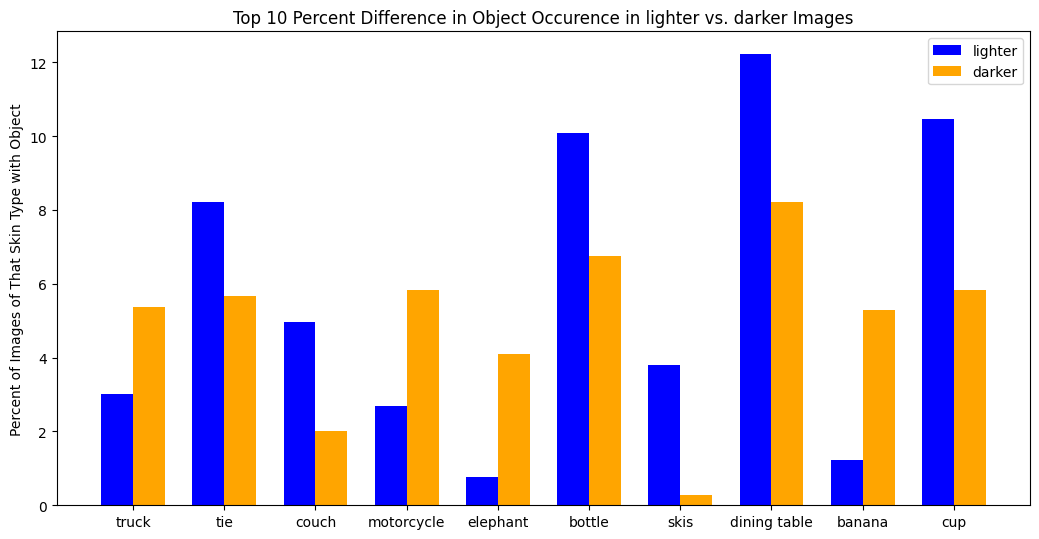

In [ ]:

labels = sorted_obj_name
men_means = [obj_per * 100 for obj_per in M_ordered_obj]
women_means = [obj_per * 100 for obj_per in F_ordered_obj]
men_means_whole = [obj_per * (9873 / 10969) * 100 for obj_per in M_ordered_obj]
women_means_whole = [obj_per * (1096 / 10969) * 100 for obj_per in F_ordered_obj]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='lighter', color = 'blue')
rects2 = ax.bar(x + width/2, women_means, width, label='darker', color = 'orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of Images of That Skin Type with Object')
ax.set_title('Top 10 Percent Difference in Object Occurence in lighter vs. darker Images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.set_size_inches(10.5, 5.5)

fig.tight_layout()

plt.show()

In [ ]:
res

{41: 0.046133338656410866,
 46: 0.04066406131593869,
 60: 0.040135819801996306,
 30: 0.035143863563608185,
 39: 0.03336294295213445,
 20: 0.03336063258862,
 3: 0.03145199508206781,
 57: 0.029456025834669646,
 27: 0.025472589477606472,
 7: 0.023648788519304655}

Logistic Regression Model

In [ ]:
# labels_val = pickle.load(open('labels_val.pkl', 'rb')) # image path name to one hot encoding
# scores_val_list = pickle.load(open('scores_val.pkl', 'rb')) # image path name to one hot encoding
# gender_labels_train = pickle.load(open('gender_labels_train.pkl', 'rb')) # image path name to one hot encoding
# gender_labels_val = pickle.load(open('gender_labels_val.pkl', 'rb')) # image path name to one hot encoding
labels_val = obj_labels

train_labels = pickle.load(open('/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard_train.pkl', 'rb'))
val_labels = pickle.load(open('/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard_val.pkl', 'rb'))

gender_labels_train = train_labels
gender_labels_val = val_labels


In [ ]:
# # convert scores to labels
# scores_val = {}
# for i, score in enumerate(scores_val_list):
#   img_path = list(labels_val.keys())[i]
#   scores_val[img_path] = score>0.5
# print(list(labels_val.keys())[:6])
# print(len(list(labels_val.keys())))

['/content/standard/COCO_val2014_000000000136.jpg', '/content/standard/COCO_val2014_000000000192.jpg', '/content/standard/COCO_val2014_000000000294.jpg', '/content/standard/COCO_val2014_000000000328.jpg', '/content/standard/COCO_val2014_000000000338.jpg', '/content/standard/COCO_val2014_000000000395.jpg']
10969


Ground Truth

In [ ]:
X_train, y_train, X_val, y_val = [], [], [], []
for img_path in list(gender_labels_train.keys()):
  gender = gender_labels_train[img_path]
  onehotenc = labels_val[img_path][1:]
  X_train.append(onehotenc)
  y_train.append(gender)

for img_path in list(gender_labels_val.keys()):
  gender = gender_labels_val[img_path]
  onehotenc = labels_val[img_path][1:]
  X_val.append(onehotenc)
  y_val.append(gender)

X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [ ]:
print(labels_val)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, class_weight = 'balanced').fit(X_train, y_train)
clf.score(X_val, y_val)

0.5843208751139471

In [ ]:
print("Dark Skinned: ", clf.score(X_val[y_val==1], y_val[tuple([y_val==1])]))
print("Light Skinned: ", clf.score(X_val[y_val==0], y_val[tuple([y_val==0])]))

Dark Skinned:  0.5352112676056338
Light Skinned:  0.5896012115093388


In [ ]:
N=10

top_10_idx = np.argsort(clf.coef_[0])[-N:]
bottom_10_idx = np.argsort(clf.coef_[0])[:N]

top_10_obj, bottom_10_obj = [], []

for idx in top_10_idx:
  top_10_obj.append(onehot_to_humanlabels[idx + 1])

for idx in bottom_10_idx:
  bottom_10_obj.append(onehot_to_humanlabels[idx + 1])

In [ ]:
top_10_obj

['orange',
 'broccoli',
 'carrot',
 'mouse',
 'bus',
 'traffic light',
 'cow',
 'stop sign',
 'banana',
 'elephant']

In [ ]:
np.sort(clf.coef_[0])[0:10]# + np.sort(clf.coef_[0])[-10:])

array([-2.19747799, -2.09660429, -1.76674685, -1.6991253 , -1.58850486,
       -1.49463497, -1.36177886, -0.99771344, -0.86295376, -0.75207865])

In [ ]:
np.array(list(np.sort(clf.coef_[0])[0:10])+list(np.sort(clf.coef_[0])[-10:]))

array([-2.19747799, -2.09660429, -1.76674685, -1.6991253 , -1.58850486,
       -1.49463497, -1.36177886, -0.99771344, -0.86295376, -0.75207865,
        0.67451642,  0.67628019,  0.71838463,  0.93362954,  0.95757339,
        0.97463378,  1.03622802,  1.05892148,  1.52513526,  1.53708138])

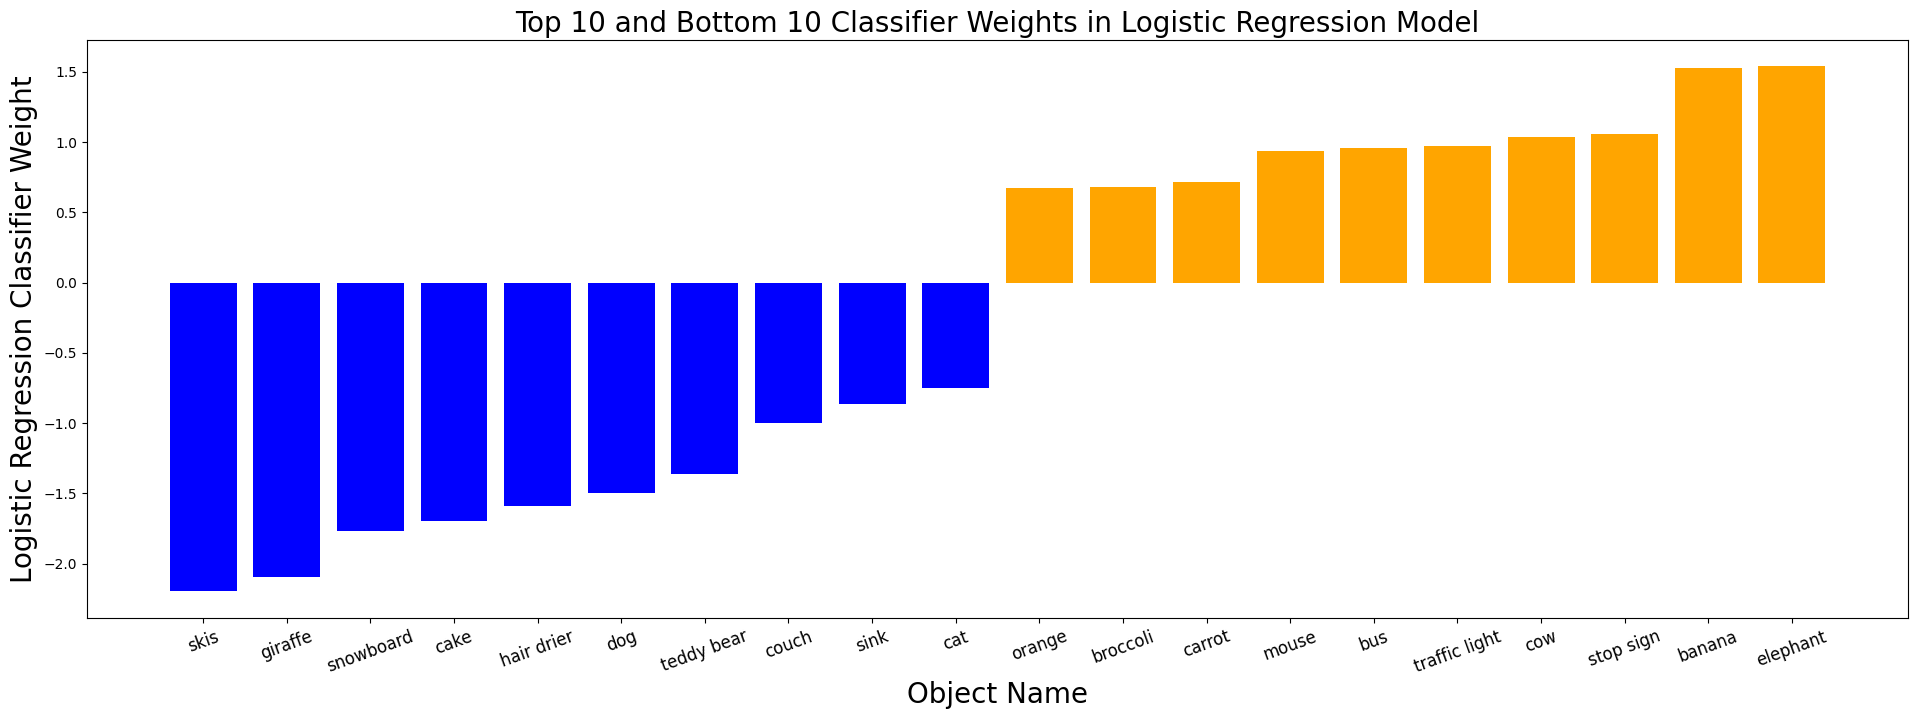

In [ ]:
'''import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(10.5, 5.5)
ax = fig.add_axes([0,0,1,1])
langs = top_10_obj
students = np.sort(clf.coef_[0])[-10:]
ax.set_ylabel('Percent of Images with Object ')
ax.set_title('Top 10 Percent Difference in Object Occurence in M vs F Images')
ax.bar(langs,students)
plt.show()'''

# report this on balanced test set

fig = plt.figure()
fig.set_size_inches(23.5, 7.5)

# create a dataset
height = np.array(list(np.sort(clf.coef_[0])[0:10])+list(np.sort(clf.coef_[0])[-10:]))
bars = bottom_10_obj + top_10_obj
x_pos = np.arange(len(bars))

# Create bars with different colors
colors = []
for i in range(10):
  colors.append('blue')
for i in range(10):
  colors.append('orange')

plt.bar(x_pos, height, color=colors)

# Create names on the x-axis
plt.xticks(x_pos, bars, fontsize=12, rotation=20)
plt.xlabel("Object Name", fontsize=20)
plt.ylabel("Logistic Regression Classifier Weight", fontsize=20)
plt.title("Top 10 and Bottom 10 Classifier Weights in Logistic Regression Model", fontsize=20)
plt.rcParams["figure.figsize"] = (25,5)
# Show graph
plt.show()

In [ ]:
top_10_idx

array([48, 49, 50, 63,  4,  8, 18, 10, 45, 19])

In [ ]:
labels_test = pickle.load(open('/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard_test.pkl', 'rb'))

X_test, y_test, y_labels = [], [], []
for img_path in list(labels_test.keys()):
  if img_path in [*random_light_ids, *dark_test]:
    skin = labels_test[img_path]
    onehotenc = labels_val[img_path][1:]
    X_test.append(onehotenc)
    y_test.append(skin)
    y_labels.append(skin)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.610738255033557

In [ ]:
from sklearn.metrics import roc_auc_score
scores_list = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, scores_list) * 100

65.24607917853275

In [ ]:
weight_list = list(np.sort(clf.coef_[0]))
positive_weights_idx = [weight_list.index(w) for w in list(np.sort(clf.coef_[0])) if w > 0]
negative_weights_idx = [weight_list.index(w) for w in list(np.sort(clf.coef_[0])) if w < 0]


In [ ]:
# largest are at the end of the list
print(positive_weights_idx)
print(negative_weights_idx)
print(len(positive_weights_idx))
print(len(negative_weights_idx))

[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
37
42


In [ ]:
dark_test = [label for label in list(labels_test.keys()) if label in dark_objs_ids]
light_test = [label for label in list(labels_test.keys()) if label in light_objs_ids]
print(len(dark_test))
print(len(light_test))
#random_light_ids = random.choices(light_test, k = 233)
print(len(random_light_ids))

233
1961
233


In [ ]:
# confidence interval for AUC
# iteratively remove most gendered objects first, then remove least gendered,
# then random objects
# check scores also, to see why 0 is weird
# create array of all positive weights and all negative weights,
# and just take out smallest positive + smallest negative




def add_auc(object_auc_dict, object_auc_ci_dict, removed_idx):

  X_train, X_val, X_test, y_test = [], [], [], []


  for img_path in list(gender_labels_train.keys()):
    gender = gender_labels_train[img_path]
    onehotenc = labels_val[img_path][1:]
    onehotenc = [enc for idx, enc in enumerate(onehotenc) if idx not in removed_idx]
    X_train.append(onehotenc)

  for img_path in list(gender_labels_val.keys()):
    gender = gender_labels_val[img_path]
    onehotenc = labels_val[img_path][1:]
    onehotenc = [enc for idx, enc in enumerate(onehotenc) if idx not in removed_idx]
    X_val.append(onehotenc)

  for img_path in list(labels_test.keys()):
    if img_path in [*random_light_ids, *dark_test]:
      gender = labels_test[img_path]
      onehotenc = labels_val[img_path][1:]
      onehotenc = [enc for idx, enc in enumerate(onehotenc) if idx not in removed_idx]
      X_test.append(onehotenc)
      y_test.append(gender)

  if len(removed_idx) == 79:
    print(X_train)



  X_train, X_val, X_test, y_test = np.array(X_train), np.array(X_val), np.array(X_test), np.array(y_test)

  clf = LogisticRegression(random_state=0, class_weight = 'balanced').fit(X_train, y_train)


  scores_list = clf.predict_proba(X_test)[:,1]
  num_objects_used = 79 - len(removed_idx)
  if len(removed_idx) == 79:
    y_pred = clf.predict(X_test)
    print(clf.score(X_test, y_test))
    print(scores_list)

  object_auc_dict[num_objects_used] = roc_auc_score(y_test, scores_list) * 100

  labels_list = y_test
  num_samples = len(y_test)
  aucs = []
  for i in range(5000):
    sampled_indices = random.choices(list(range(0, num_samples)), k = num_samples)
    sampled_labels = [labels_list[i] for i in sampled_indices]
    sampled_scores = [scores_list[i] for i in sampled_indices]
    try:
      sample_auc = roc_auc_score(sampled_labels, sampled_scores)
    except:
      continue
    aucs.append(sample_auc)

  confidence_interval = np.percentile(aucs, (2.5, 97.5))
  object_auc_ci_dict[num_objects_used] = confidence_interval



most_racial_objects_auc = {}
least_racial_objects_auc = {}
random_objects_auc = {}
most_racial_objects_auc_ci = {}
least_racial_objects_auc_ci = {}
random_objects_auc_ci= {}
sorted_objects_idx = np.argsort(clf.coef_[0])
removed_most_idx = []
removed_least_idx = []
removed_random_idx = []
rand_indices = list(range(0,79))
random.shuffle(rand_indices)

for i in range(0, len(negative_weights_idx) - 1):
  # print("i:", i)
  # print("num removed:", len(removed_most_idx))

  if (i < 40):
    rand_index1 = rand_indices.pop()

    if len(rand_indices) > 2:
      rand_index2 = rand_indices.pop()
      removed_random_idx.append(rand_index2)

    removed_random_idx.append(rand_index1)

    if not rand_indices:
      print("empty")
    add_auc(random_objects_auc, random_objects_auc_ci, removed_random_idx)

  if (i < len(positive_weights_idx)):
    removed_most_idx.append(positive_weights_idx[-i])
    removed_least_idx.append(positive_weights_idx[i])


  if (i < len(negative_weights_idx)):
    removed_most_idx.append(negative_weights_idx[i])
    removed_least_idx.append(negative_weights_idx[-i])



  add_auc(most_racial_objects_auc, most_racial_objects_auc_ci, removed_most_idx)
  add_auc(least_racial_objects_auc, least_racial_objects_auc_ci, removed_least_idx)




print(most_racial_objects_auc)
print(least_racial_objects_auc)
print(random_objects_auc)




{77: 65.28848581360573, 75: 65.0369953197522, 73: 64.95057580642029, 71: 64.62140485114482, 69: 65.0175752043967, 67: 65.44967277105626, 65: 64.1359019672577, 63: 64.19027829025303, 61: 63.30180801273959, 59: 64.1242498980444, 57: 64.45730487639096, 55: 64.42720369758996, 53: 63.883440467636376, 51: 63.161983182180094, 49: 63.127026974540236, 47: 61.445244984755206, 45: 62.02008039927757, 43: 62.062804653059644, 41: 60.87623560483949, 39: 59.84696949099879, 37: 60.27615404035499, 35: 60.18876352125532, 33: 59.36146660711164, 31: 58.72739984075505, 29: 57.9107839900569, 27: 58.98277435767969, 25: 57.694249703843234, 23: 57.09416813935875, 21: 57.03687879906006, 19: 55.27741634785311, 17: 55.36383586118501, 15: 55.37354591886277, 13: 55.30363350358303, 11: 56.24842211562736, 9: 54.403511156856275, 7: 53.61505447342358, 5: 52.02746004311265, 4: 52.6634688210048, 3: 52.776105490066605, 2: 53.139261647214184, 1: 50.53405317227584}
{77: 65.28848581360573, 75: 65.13700891383296, 73: 65.143805

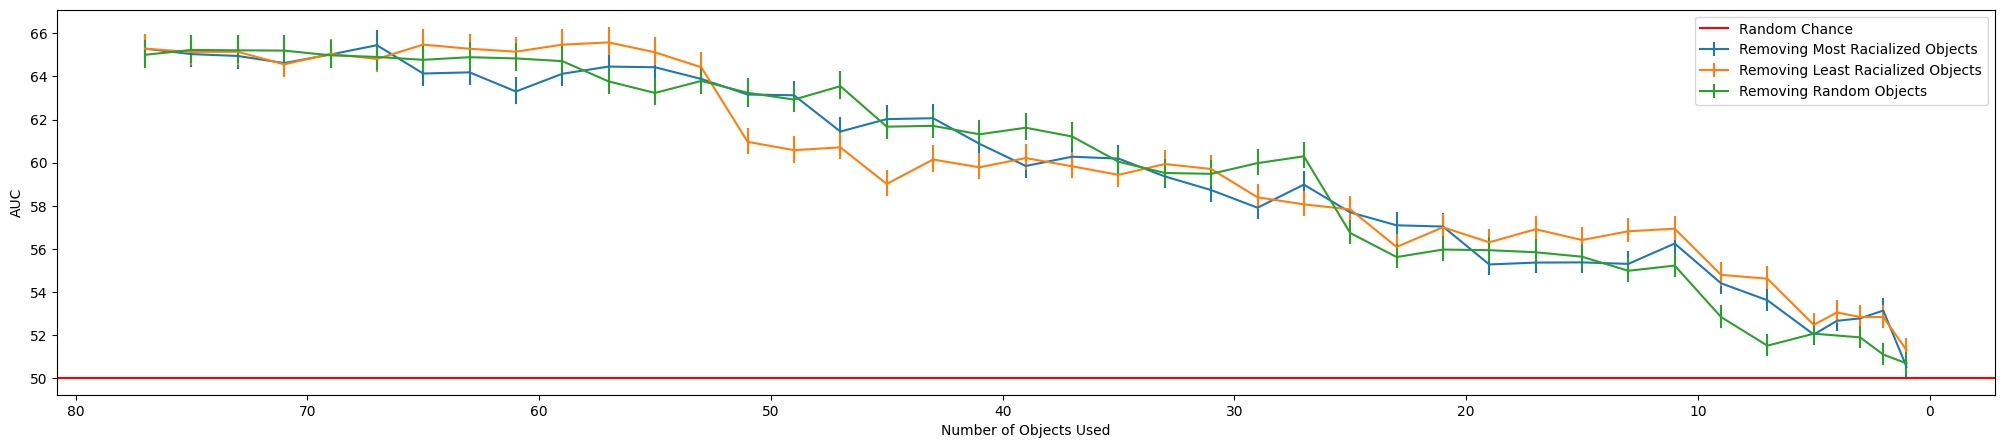

In [ ]:
lower_bounds_m = [ci[0] for ci in most_racial_objects_auc_ci.values()]
upper_bounds_m = [ci[1] for ci in most_racial_objects_auc_ci.values()]
plt.errorbar(list(most_racial_objects_auc.keys()), list(most_racial_objects_auc.values()), yerr = [lower_bounds_m, upper_bounds_m], label = "Removing Most Racialized Objects")
lower_bounds_l = [ci[0] for ci in most_racial_objects_auc_ci.values()]
upper_bounds_l = [ci[1] for ci in least_racial_objects_auc_ci.values()]
plt.errorbar(list(least_racial_objects_auc.keys()), list(least_racial_objects_auc.values()), yerr = [lower_bounds_l, upper_bounds_l], label = "Removing Least Racialized Objects")
lower_bounds_r = [ci[0] for ci in random_objects_auc_ci.values()]
upper_bounds_r = [ci[1] for ci in random_objects_auc_ci.values()]
plt.errorbar(list(random_objects_auc.keys()), list(random_objects_auc.values()), yerr = [lower_bounds_r, upper_bounds_r], label = "Removing Random Objects")
plt.axhline(50, color = "red", label = "Random Chance")
plt.ylabel("AUC")
plt.xlabel("Number of Objects Used")
plt.legend()
plt.gca().invert_xaxis()


In [ ]:


most_racial_aucs = {78: 0.6054468859397559, 76: 0.6051205474575265, 74: 0.6033800755523031, 72: 0.5908012104190977, 70: 0.5913648859793121, 68: 0.5914835545183046, 66: 0.592996578390459, 64: 0.5814461739285219, 62: 0.5839184351575326, 60: 0.5760665334941951, 58: 0.5775696683214335, 56: 0.5814956191531022, 54: 0.5814165067937739, 52: 0.5784992385435415, 50: 0.5763632048416765, 48: 0.5792508059571606, 46: 0.5847194477957318, 44: 0.5828899744862641, 42: 0.5804374913470859, 40: 0.5710330096319297, 38: 0.5652479183560452, 36: 0.5661873776230691, 34: 0.5627855461719508, 32: 0.5447677063349221, 30: 0.5417416585906133, 28: 0.5429382330254544, 26: 0.5354423369790945, 24: 0.5333953046814739, 22: 0.53155594232709, 20: 0.5292517948616523, 18: 0.5232689226874468, 16: 0.5149917920927197, 14: 0.5195506417990151, 12: 0.5281244437412234, 10: 0.5157136923715907, 8: 0.5180771741065248, 6: 0.5057653131860526, 5: 0.507743122169261, 4: 0.5135578805798935, 3: 0.5081584620557347, 2: 0.5098099325567137, 1: 0.4988034255651589}
least_racial_aucs = {78: 0.6054468859397559, 76: 0.6104705207571053, 74: 0.6114297581139614, 72: 0.602885623306501, 70: 0.6069697988568264, 68: 0.6053578845355115, 66: 0.6095706176697455, 64: 0.608512489863729, 62: 0.618401534779771, 60: 0.6163050572575701, 58: 0.6143569154091097, 56: 0.608275152785744, 54: 0.5954095053499733, 52: 0.5955380629338818, 50: 0.594875496924507, 48: 0.5799924843258638, 46: 0.5812978382547813, 44: 0.5833943157769822, 42: 0.5788948003401831, 40: 0.5780146753426554, 38: 0.5820296275785685, 36: 0.5872510432942386, 34: 0.5898419730622416, 32: 0.5832459801032416, 30: 0.5960720713593481, 28: 0.5920867862581831, 26: 0.5742073930499791, 24: 0.5713197919344949, 22: 0.5748007357449417, 20: 0.5753644113051561, 18: 0.5710428986768458, 16: 0.5732778228278713, 14: 0.5777872273095865, 12: 0.5636360040347304, 10: 0.5596902751132296, 8: 0.5400605209548863, 6: 0.5469334071715353, 5: 0.5303000336227527, 4: 0.5303000336227527, 3: 0.5133106544569925, 2: 0.5107296137339056, 1: 0.4988034255651589}
random_aucs = {78: 0.6025098395996915, 76: 0.598870671070588, 74: 0.5901979786792191, 72: 0.5907418761496015, 70: 0.5882201696960108, 68: 0.5858467989161606, 66: 0.5850853424576254, 64: 0.5744150629932161, 62: 0.5723581416506793, 60: 0.5605308439310932, 58: 0.5535195110856194, 56: 0.5551610925416823, 54: 0.5502660153082415, 52: 0.5479420897529717, 50: 0.5465872905994739, 48: 0.5439073594272265, 46: 0.5482090939657047, 44: 0.5509384703625325, 42: 0.5485255434030182, 40: 0.5400704099998022, 38: 0.5403670813472835, 36: 0.5458456122307708, 34: 0.5465180672850616, 32: 0.5526294970431755, 30: 0.5567235616384169, 28: 0.528965012559087, 26: 0.5267399774529775, 24: 0.5241094915053104, 22: 0.5240897134154784, 20: 0.5248907260536778, 18: 0.5306263721049822, 16: 0.5316449437313345, 14: 0.5343149858586659, 12: 0.5298055813769506, 10: 0.5314867190126777, 8: 0.5131029845137557, 6: 0.5130238721544274, 4: 0.5112042878898756, 2: 0.509404481715156, 1: 0.4930875576036866}


NN Accuracy

In [ ]:
F_objects_imgid = pickle.load(open('F_objects_imgid.pkl', 'rb'))
M_objects_imgid = pickle.load(open('M_objects_imgid.pkl', 'rb'))
gender_labels_test = pickle.load(open('gender_labels_test.pkl', 'rb')) # image path name to one hot encoding

In [ ]:
F_COUNT, M_COUNT = 0, 0
for imgpath in M_objects_imgid:
  if (gender_labels_test[imgpath]==0):
    M_COUNT+=1
for imgpath in F_objects_imgid:
  if (gender_labels_test[imgpath]==1):
    F_COUNT+=1

KeyError: '/content/standard/COCO_val2014_000000000241.jpg'

In [ ]:
print("Female: ", F_COUNT/F_IMGS)
print("Male: ", M_COUNT/M_IMGS)

Female:  0.2798507462686567
Male:  0.7


In [ ]:
M_COUNT, M_IMGS

(1134, 1620)

In [ ]:
img_path

'/n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000581357.jpg'

In [ ]:
female_top10 = top_10_idx
male_top10 = bottom_10_idx

female_img_id = []
female_img_id_top10 = []
male_img_id = []
male_img_id_top10 = []

for img_path in list(gender_labels_test.keys()):
  objects = np.where(labels_val[img_path]==1)[0]
  img_id = int(img_path.split('/')[-1][:-4][-12:])
  top10=False
  # if female
  if gender_labels_test[img_path]:
    for o in objects:
      # find out if the objects in this image contain objects from top 10
      if o in female_top10:
        top10=True
        break
    if top10: female_img_id_top10.append(img_id)
    else: female_img_id.append(img_id)

  # if male
  else:
    for o in objects:
      # find out if the objects in this image contain objects from top 10
      if o in male_top10:
        top10=True
        break
    if top10: male_img_id_top10.append(img_id)
    else: male_img_id.append(img_id)

In [ ]:
print(len(female_img_id), len(female_img_id_top10), len(male_img_id), len(male_img_id_top10))

440 196 856 664


In [ ]:
from scipy.stats import ttest_ind_from_stats

# stat sig between all female and all male

# stat sig between all top 10 vs all not top 10

ttest_ind_from_stats(mean1=0.209, std1=0.1, nobs1=440+196,
                     mean2=0.218, std2=0.1, nobs2=856+664)

Ttest_indResult(statistic=-1.9057612097262402, pvalue=0.05681419525738061)

In [ ]:
ls

classifier.py                         humanlabels_to_onehot.pkl
COCO_val2014_000000022341_female.png  labels_val.pkl
COCO_val2014_000000242365_female.png  load_data.py
F_objects_imgid.pkl                   M_objects_imgid.pkl
F_objects.pkl                         M_objects.pkl
gender_labels_test.pkl                __pycache__/
gender_labels_train.pkl               scores_val.pkl
gender_labels_val.pkl


In [ ]:
import numpy as np
import PIL
import torch
import sys
import os
import cv2
import argparse
import matplotlib.pyplot as plt
import torchvision.transforms as T

from PIL import Image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from classifier import multilabel_classifier
from load_data import *

###
# Referenced from:
# https://github.com/jacobgil/pytorch-grad-cam/blob/master/gradcam.py
#
# Example usage:
# python get_cams.py --modelpath $MODELPATH --img_ids 535811 430054 554674
#
# --modelpath: path to the model to visualize
# --img_ids: COCOStuff image IDs (use the Explore tool on the COCO dataset website)
###

def get_heatmap(CAM_map, img):
    CAM_map = cv2.resize(CAM_map, (img.shape[0], img.shape[1]))
    CAM_map = CAM_map - np.min(CAM_map)
    CAM_map = CAM_map / np.max(CAM_map)
    CAM_map = 1.0 - CAM_map # make sure colormap is not reversed
    heatmap = cv2.applyColorMap(np.uint8(255 * CAM_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap + np.float32(img)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    return heatmap

def returnCAM(feature_conv, weight_softmax, class_labels, device):
    bz, nc, h, w = feature_conv.shape # (1, hidden_size, height, width)
    output_cam = torch.Tensor(0, 7, 7).to(device=device)
    for idx in class_labels:
        cam = torch.mm(weight_softmax.unsqueeze(0), feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - cam.min()
        cam_img = cam / cam.max()
        output_cam = torch.cat([output_cam, cam_img.unsqueeze(0)], dim=0)
    return output_cam

def returnCAM_featuresplit(feature_conv, weight_softmax, class_labels, device, split=1024):
    feature_conv_o = feature_conv[:,:split,:,:]
    feature_conv_s = feature_conv[:,split:,:,:]
    bz, nc, h, w = feature_conv.shape
    output_cam = torch.Tensor(0, 7, 7).to(device=device)
    for idx in class_labels:
        cam_o = torch.mm(weight_softmax[idx][:split].unsqueeze(0), feature_conv_o.reshape((split, h*w)))
        cam_s = torch.mm(weight_softmax[idx][split:].unsqueeze(0), feature_conv_s.reshape((nc-split, h*w)))
        cam_o = cam_o.reshape(h, w)
        cam_s = cam_s.reshape(h, w)
        cam_o = cam_o - cam_o.min()
        cam_s = cam_s - cam_s.min()
        cam_o_img = cam_o / cam_o.max()
        cam_s_img = cam_s / cam_s.max()
        output_cam = torch.cat([output_cam, cam_o_img.unsqueeze(0), cam_s_img.unsqueeze(0)], dim=0)
    return output_cam

def main():
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--modelpath', type=str, default=None)
    # parser.add_argument('--img_ids', type=int, nargs='+', default=0)
    # parser.add_argument('--outdir', type=str, default=None)
    # parser.add_argument('--featuresplit', default=False, action="store_true")
    # parser.add_argument('--split', type=int, default=1024)
    # parser.add_argument('--coco2014_images', type=str, default='/n/fs/visualai-scr/Data/Coco/2014data')
    # parser.add_argument('--device', default=torch.device('cuda'))
    # parser.add_argument('--dtype', default=torch.float32)
    # arg = vars(parser.parse_args())
    arg = {'modelpath': 'model_199.pth',
           'img_ids': [22341, 242365],
           'outdir': None,
           'featuresplit': False,
           'split': 1024,
           'coco2014_images': '',
           'device': torch.device('cuda'),
           'dtype': torch.float32}
    print(arg, '\n', flush=True)

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = T.Compose([
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor()
    ])

    classifier_features = []
    def hook_classifier_features(module, input, output):
        classifier_features.append(output)

    classifier = multilabel_classifier(device=arg['device'], dtype=arg['dtype'], modelpath=arg['modelpath'])
    classifier.model = classifier.model.to(device=classifier.device, dtype=classifier.dtype)

    classifier.model._modules['resnet'].layer4.register_forward_hook(hook_classifier_features)
    classifier_params = list(classifier.model.parameters())
    classifier_softmax_weight = classifier_params[-2].squeeze(0)

    for img_id in arg['img_ids']:
        # Open image
        img_path = '{}/train2014/COCO_train2014_{:012d}.jpg'.format(arg['coco2014_images'], img_id)
        img_name = img_path.split('/')[-1][:-4]
        if not os.path.exists(img_path):
            # Try searching in val set
            img_path = '{}/val2014/COCO_val2014_{:012d}.jpg'.format(arg['coco2014_images'], img_id)
            print('img_path: ', img_path)
            img_name = img_path.split('/')[-1][:-4]
            if not os.path.exists(img_path):
                print('WARNING: Could not find img {}'.format(img_id), flush=True)
                continue
        original_img = Image.open(img_path).convert('RGB')

        if arg['outdir'] != None:
            outdir = '{}/{}'.format(arg['outdir'], img_id)
        else:
            outdir = str(img_id)
        if not os.path.exists(outdir):
            os.makedirs(outdir)
        print('Processing img {}'.format(img_id), flush=True)

        # Get image class labels
        img_labels = pickle.load(open('data/gender_labels_train.pkl', 'rb'))
        if img_path in img_labels:
            if torch.cuda.device_count() > 0:
                class_labels = img_labels[img_path].type('torch.cuda.ByteTensor')
            else:
                class_labels = img_labels[img_path].type('torch.ByteTensor')
        else:
            img_labels = pickle.load(open('data/gender_labels_test.pkl', 'rb'))
            if img_path in img_labels:
                if torch.cuda.device_count() > 0:
                    class_labels = [img_labels[img_path]]
                    #class_labels = img_labels[img_path].type('torch.cuda.ByteTensor')
                else:
                    class_labels = [img_labels[img_path]]
                    class_labels = img_labels[img_path].type('torch.ByteTensor')
            else:
                print('No labels found for image {}'.format(img_path), flush=True)
                class_labels = torch.zeros(1)
        #class_labels = torch.flatten(torch.nonzero(class_labels))
        class_labels = torch.FloatTensor(class_labels)
        classifier_features.clear()
        img = transform(original_img)
        norm_img = normalize(img)
        norm_img = norm_img.to(device=classifier.device, dtype=classifier.dtype)
        norm_img = norm_img.unsqueeze(0)
        x = classifier.forward(norm_img)

        if arg['featuresplit']:
            CAMs = returnCAM_featuresplit(classifier_features[0], classifier_softmax_weight, class_labels, arg['device'], split=arg['split'])
        else:
            CAMs = returnCAM(classifier_features[0], classifier_softmax_weight, class_labels, arg['device'])
        CAMs = CAMs.detach().cpu().numpy()

        # Save CAM heatmap
        #humanlabels_to_onehot = pickle.load(open('/n/fs/context-scr/data/COCOStuff/humanlabels_to_onehot.pkl', 'rb'))
        #onehot_to_humanlabels = {v: k for k,v in humanlabels_to_onehot.items()}
        onehot_to_humanlabels= {0: 'male',
                                1: 'female'}
        img = np.moveaxis(img.detach().cpu().numpy(), 0, -1)
        class_labels = class_labels.cpu().detach().numpy()
        if arg['featuresplit']:
            for i in range(len(class_labels)):
                heatmap_o = get_heatmap(CAMs[2*i], img)
                heatmap_s = get_heatmap(CAMs[2*i+1], img)

                fig = plt.figure()
                fig_o = fig.add_subplot(121)
                fig_o.imshow(heatmap_o)
                fig_o.axis('off')
                fig_o.set_title('{} ({})'.format(onehot_to_humanlabels[class_labels[i]], 'Wo'))

                fig_s = fig.add_subplot(122)
                fig_s.imshow(heatmap_s)
                fig_s.axis('off')
                fig_s.set_title('{} ({})'.format(onehot_to_humanlabels[class_labels[i]], 'Ws'))
                humanlabel = onehot_to_humanlabels[class_labels[i]].replace(' ', '+')
                plt.savefig('{}/{}_{}.png'.format(outdir, img_name, humanlabel))
                plt.show()
                plt.close()
        else:
            for i in range(len(class_labels)):
                heatmap = get_heatmap(CAMs[i], img)
                plt.figure()
                plt.imshow(heatmap)
                plt.axis('off')
                plt.title(onehot_to_humanlabels[class_labels[i]])
                humanlabel = onehot_to_humanlabels[class_labels[i]].replace(' ', '+')
                plt.savefig('{}/{}_{}.png'.format(outdir, img_name, humanlabel))
                plt.show()
                plt.close()

if __name__ == '__main__':
    main()


